# Variational Quantum Eigensolver

The Variational Quantum Eigensolver (VQE) is a hybrid quantum–classical algorithm designed to approximate the ground-state energy of a Hamiltonian $H$ by optimizing a parameterized quantum state $|\psi(\theta)\rangle$. In this tutorial, we assume minimal familiarity with the concept of a quantum Hamiltonian and build the necessary background step by step.

We begin by formulating the problem and motivating it through classical mechanics and classical Hamiltonian formulations, before transitioning to  quantum Hamiltonian formulation. Along the way, we introduce tools and concepts, including time evolution operators and representative examples of physical Hamiltonians. We then focus on the hydrogen atom as an example, which allows us to develop intuition.

From there, we move away from abstract operator formalism toward numerical representations relevant for computation. This includes the Born-Oppenheimer approximation, first and second quantization formalisms, the construction of fermionic Hamiltonians, truncation of infinite-dimensional Hilbert spaces, the choice of finite orbital bases, and the mapping of fermionic operators to qubit Hamiltonians. With this foundation in place, we introduce the VQE algorithm in detail and apply it to the helium hydride cation $\mathrm{HeH}^{+}$, which served as a benchmark system in the original VQE proposal by Peruzzo et al. in [A variational eigenvalue solver on a quantum processor](https://arxiv.org/abs/1304.3061).

Finally, we examine the resource complexity of VQE from a heuristic perspective, discuss its limitations and practical considerations, and outline strategies for mitigating its main bottlenecks. We conclude by highlighting several important applications of ground-state energy estimation, ranging from theoretical physics to quantum chemistry and drug discovery. By the end of this tutorial, is is hoped that the reader has a clear understanding of how Hamiltonians are constructed and represented, how VQE is used to approximate ground-state energies and how to interpret its results.


### Problem Statement 

> Given a Hamiltonian $H$ describing a quantum system, find an approximation of its ground-state energy $E_0$ and the corresponding quantum state $|\psi(\theta)\rangle$ such that:
>
> $$E_0 \approx \min_{\theta} \langle \psi(\theta) | H | \psi(\theta) \rangle,$$
>
> where $|\psi(\theta)\rangle$ is a parameterized quantum state, and $\theta$ is a set of classical parameters.

While the above formulation provides an approximate variational method, where the optimal $\theta$ minimizes the energy, its exact version arises from the eigenvalue equation. Let $E_0$ be the true ground-state eigenvalue of $H$. Then:

$$H|\psi_0\rangle = E_0|\psi_0\rangle,$$

which is equivalent to the Rayleigh-Ritz variational principle:

$$E_0 = \min_{|\psi\rangle \in \mathcal{H}} \langle \psi | H | \psi \rangle,$$

where $\mathcal{H}$ denotes the full Hilbert space of the system.

Thus, VQE approximates the exact ground-state eigenvalue by restricting the search to a parameterized family of states prepared on a quantum computer.

### From Classical to Quantum Hamiltonians

First, we provide context for the VQE problem by reviewing Hamiltonian mechanics in both its classical and quantum formulations, and by explaining how the Hamiltonian operator arises in quantum mechanics through the Schrödinger equation.

Classical mechanics provides the non-quantum description of physical systems and can be expressed through several equivalent formulations. The three core formalisms are Newtonian, Lagrangian, and Hamiltonian mechanics. Although these do not exhaust the full scope of classical mechanics, together they cover a large portion of its foundational structure. These three formalisms are closely related and each is suited to different types of problems. Although we will not explore their full mathematical structure here, we can briefly outline the role of each. Newtonian mechanics uses forces to determine acceleration through $F = ma$. Lagrangian mechanics determines the physical trajectory by selecting the path that optimizes the action $S = \int (T - V)\, dt$, where $T$ and $V$ denote the kinetic and potential energies, respectively. Hamiltonian mechanics describes motion in terms of positions $q$ and momenta $p$, whose time evolution is governed by the canonical equations $\dot{q} = \partial H / \partial p$ and $\dot{p} = -\,\partial H / \partial q$, where $H$ represents the system's total energy. 

These classical descriptions are particularly important because the Lagrangian and Hamiltonian formalisms extend naturally into quantum mechanics. The Lagrangian leads to Feynman’s path-integral formulation, in which quantum amplitudes are obtained by summing $e^{iS/\hbar}$ over all possible paths, where $\hbar$ is the reduced Planck constant that sets the fundamental scale of quantum effects. The Hamiltonian, on the other hand, becomes an operator $\hat{H}$ acting on states in Hilbert space and generates time evolution through the Schrödinger equation $i\hbar\,\partial_t |\psi\rangle = \hat{H} |\psi\rangle$. For example, see [Notes on Quantum Mechanics using Lagrangian approach](https://rgjha.github.io/notes/QMPI_Notes.pdf) on the connection between quantum mechanics and Lagrangian mechanics. 

In the classical case, the Hamiltonian is a function $H(q, p)$ that represents the total energy of a system.

For example, a simple harmonic oscillator:
$$H(q, p) = \frac{p^2}{2m} + \frac{1}{2}kq^2$$

The classical Hamiltonian:
- Takes real-valued inputs (positions and momenta)
- Returns a real-valued output (the total energy)
- Variables commute: $qp = pq$ (multiplication of real numbers)
- Observables can be known simultaneously with arbitrary precision

In the quantum case, the Hamiltonian is an operator $\hat{H}$ acting on quantum states in a Hilbert space.

For the same harmonic oscillator:
$$\hat{H} = \frac{\hat{p}^2}{2m} + \frac{1}{2}k\hat{q}^2$$

where $\hat{q}$ and $\hat{p}$ are operators, not numbers.

The quantum Hamiltonian:
- Is a linear operator 
- Acts on quantum state vectors $|\psi\rangle$
- Has eigenvalues (energy levels) and eigenvectors (energy eigenstates)
- Operators generally do not commute: $[\hat{q}, \hat{p}] = \hat{q}\hat{p} - \hat{p}\hat{q} = i\hbar \neq 0$


Both classical and quantum Hamiltonians:
1. Represent the total energy of the system
2. Consist of kinetic energy + potential energy terms
3. Govern the time evolution of the system
   - Classical: Hamilton's equations $\frac{dq}{dt} = \frac{\partial H}{\partial p}$, $\frac{dp}{dt} = -\frac{\partial H}{\partial q}$.
   - Quantum: Schrödinger equation $i\hbar\frac{\partial}{\partial t}|\psi (t) \rangle = \hat{H}|\psi (t) \rangle$. 

The quantum Hamiltonian itself is Hermitian, and it's built from operators like $\hat{q}$ and $\hat{p}$ that don't commute with each other. This non-commutativity $[\hat{q}, \hat{p}] = i\hbar$ is the mathematical foundation of the Heisenberg uncertainty principle:

$$\Delta q \cdot \Delta p \geq \frac{\hbar}{2}$$

This means position and momentum cannot be simultaneously known with arbitrary precision, a fundamental feature of quantum mechanics that has no classical analog.


The difference between the Hamiltonian being a function (classical) versus an operator (quantum) is an important one. In short, the classical Hamiltonian is a function because the classical state is a point in phase space, while the quantum Hamiltonian is an operator because the quantum state is a vector in Hilbert space and must accommodate the intrinsic uncertainty and non-commutativity of quantum observables.

### Time Evolution Operator

While the Hamiltonian $\hat{H}$ provides a description of how the quantum system works, the time evolution operator tells us how the quantum system changes over time. The time evolution operator arises from the solution to Schrödinger equation. Note that the Schrödinger equation has two time-dependent Schrödinger equation (TDSE) and time-independent Schrödinger equation (TISE) versions, depending on whether the Hamiltonian depends on time or not. If the Hamiltonian does not depend on time, $\hat{H}(t) = \hat{H}$, then the time-evolution operator has a simple closed form: $U(t) = e^{i \hat{H}t/\hbar}$ with $|\psi(t) \rangle = U(t) | \psi(0) \rangle$ and $U(0) = I$, which is the solution to opeartor differetial equation of Schrödinger equation. If the Hamiltonian does explicitly depend on time $\hat{H}(t_1) \neq \hat{H}(t_2)$ the operators at different times generally do not commute, $[\hat{H}(t_1), \hat{H}(t_2)] \neq 0$ meaning a simple exponential is no longer correct. The solution becomes the time-ordered exponential, often called the [Dyson series](https://en.wikipedia.org/wiki/Dyson_series),:

$$
U(t) = \mathcal{T} e^{\frac{i}{\hbar} \int_0^t \hat{H}(t')dt'}
$$
where $\mathcal{T}$, the time-ordering operator ensure the correct oredering of non-commutating Hamiltonians.

Quantum gates can be viewed as instances of time evolution operators. For example, the Pauli $X$ gate can be written as $X = e^{-i \frac{\pi}{2} X}$ up to a global phase, and more generally single-qubit rotation gates take the form $R_\alpha(\theta) = e^{-i \frac{\theta}{2} \sigma_\alpha}$ with $\alpha \in \{x, y, z\}$. The Hadamard gate can be written as $H = e^{-i \frac{\pi}{2} \hat{n}\cdot\vec{\sigma}}$ up to a global phase, where the rotation axis is $\hat{n} = \frac{1}{\sqrt{2}}(1,0,1)$, so that $\hat{n}\cdot\vec{\sigma} = \frac{(X+Z)}{\sqrt{2}}$, therefore, $H = e^{-i \frac{\pi}{2} \frac{X+Z}{\sqrt{2}}}$. Similarly, the $T$ gate is given by $T = e^{-i \frac{\pi}{8} Z}$, and the CNOT gate can be written as $\text{CNOT} = e^{-i \frac{\pi}{4} (I - Z) \otimes X}$ up to a global phase. These expressions highlight the close connection between quantum gates and time evolution operators.

A time-independent Hamiltonian may be composed of terms that do not commute with one another. For example, a Hamiltonian may be written as
$$
H = H_1 + H_2 + \cdots + H_m,
$$
where individual terms satisfy $[H_i, H_j] \neq 0$ for some $i \neq j$, even though the full Hamiltonian is time independent and therefore satisfies $[H(t_1), H(t_2)] = 0$.

The corresponding time evolution operator is
$$
U(t) = e^{-i H t} = e^{-i (H_1 + H_2) t}.
$$
In practice, implementing an arbitrary unitary often requires decomposing it into simpler, native operations generated by the individual terms of the Hamiltonian. When $[H_1, H_2] \neq 0$, the exponential of the sum does not factorize:
$$
e^{-i (H_1 + H_2) t} \neq e^{-i H_1 t} \, e^{-i H_2 t}.
$$

Trotterization provides an approximation to the full time evolution by splitting it into short evolutions under the individual terms,
$$
e^{-i (H_1 + H_2) t} \approx \left( e^{-i H_1 \frac{t}{n}} \, e^{-i H_2 \frac{t}{n}} \right)^n,
$$
where the approximation becomes exact in the limit $n \to \infty$.

Because the terms do not commute, it is important to note that
$$
\left( e^{-i H_1 \frac{t}{n}} \, e^{-i H_2 \frac{t}{n}} \right)^n \neq \left( e^{-i H_1 \frac{t}{n}} \right)^n \left( e^{-i H_2 \frac{t}{n}} \right)^n =
e^{-i (H_1 + H_2) t}.
$$

Beyond Trotterization, several other methods have been developed for simulating time evolution, including:
- Taylor series expansions,
- Linear Combination of Unitaries (LCU),
- Qubitization,
- Quantum Singular Value Transformation (QSVT),
- Krylov subspace methods.

### Examples of Physical Hamiltonians

So far, we have treated the Hamiltonian as an abstract operator acting on an infinite-dimensional Hilbert space. By projecting onto a finite basis or truncating the Hilbert space, the Hamiltonian can be represented in finite form with computable numerical coefficients.

In its most general form, the Hamiltonian is written abstractly as

$$
\hat{H} = \text{(kinetic energy)} + \text{(potential energy)}.
$$

This operator acts on wavefunctions in an infinite-dimensional Hilbert space. Once a physical system is specified, its parameters are fixed (for example, masses and charges), and a particular representation is chosen (such as a basis set), the Hamiltonian admits a concrete numerical representation.


Below are examples of Hamiltonians:

**1D Harmonic Oscillator**

$$
\hat{H}
= -\frac{p^2}{2m}
+ \frac{1}{2}m\omega^2 x^2.
$$

If truncated to the first $N$ oscillator eigenstates, this becomes an $N \times N$ numerical matrix.

**Hydrogen Atom**

$$
\hat{H}
= -\frac{\hbar^2}{2m_e} \nabla^2
\;-\;
\frac{e^2}{4\pi \epsilon_0 r}, \qquad (*)
$$
where

 - $m_e$ is the electron mass,
 - $\nabla^2$ is the Laplacian operator
 - $e$ is the electron charge
 - $\epsilon_0$ is vacuum premittivity
 - $r$ is the distance between electron and the proton (nucleus). 

This Hamiltonian describes the kinetic energy of the electron and the Coulomb attraction to the nucleus which acts on the infinite-dimensional space $L^2(\mathbb{R}^3)$. But if we choose a finite basis, then the Hamiltonian can be represented as a finite matrix in the chosen basis. Thus the infinite-dimensional problem is reduced to an $N_{\text{basis}} \times N_{\text{basis}}$ matrix eigenvalue problem. 



**Ising Model (Transverse-Field Ising Model)**

$$
\hat{H}
= -J \sum_{\langle i,j\rangle} Z_i Z_j
\;-\;
h \sum_{i} X_i,
$$
where 

 - $J$ is the coupling strength between neighboring spins
 - $\langle i,j \rangle$ is the sum over neighboring spin pairs on the lattice
 - $Z_i$ is the Pauli-$Z$ operator acting on spin $i$
 - $X_i$ is the Pauli-$X$ operator acting on spin $i$
 - $h$ strength of an external transverse magnetic field. 


This model represents spins arranged on a lattice, where neighboring spins tend to align or anti-align depending on $J$, while a magnetic field $h$ tries to flip them.

**Heisenberg Model (XXX Model)**

$$
H = J\sum_{\langle i,j\rangle} \left( X_i X_j + Y_i Y_j + Z_i Z_j \right),
$$
where 
 - $J$ is the interaction strength
 - $X_i$, $Y_i$, $Z_i$ are the Pauli matrice acting on spin $i$
 - $\langle i,j \rangle$ sum over nearest-neighbor pairs.

This model describes spins that interact in all spatial directions,

**Hubbard Model**

$$
H = -t \sum_{\langle i,j\rangle,\sigma} c_{i\sigma}^\dagger c_{j\sigma} + U \sum_i n_{i\uparrow} n_{i\downarrow},
$$
where 
 - $t$ is the hopping amplitude (how easily electrons move between sites)
 - $\langle ij \rangle$ is the nearest-neighbor sites on a lattice
 - $\sigma \in \{ \uparrow,\downarrow \}$ is the electron spin index
 - $c_{i \sigma}^\dagger$ is the fermionic creation operator (create an electron of spin $\sigma$ at site $i$)
 - $c_{j \sigma}$ is the fermionic annihilation operator
 - $n_{i\uparrow}$ and $n_{i\downarrow}$ are the occupation numbers for spin-up and spin-down electrons at site $i$
 - $U$ is the on-site Coulomb repulsion when two electrons occupy the same site. 

The Hubbard model is a simplified model in condensed matter physics that describes the behavior of interacting electrons in a solid material. It is a fundamental model for understanding phenomena like magnetism and high-temperature superconductivity. The Hubbard model is defined on a lattice. Its Hamiltonian considers two physical effects:

1. Hopping (Kinetic Energy): Electrons can "hop" or tunnel from one site (atom) to a neighboring site. This term drives motion and delocalization.
2. On-site Interaction (Potential Energy): Electrons experience a strong electrostatic repulsion if two of them occupy the same site. This term restricts motion and favors localization.

The ratio of the interaction strength to the hopping strength $U/t$ determines the material's properties, which can range from a metal to an insulator.

### The Hydrogen Atom as a Warm-Up Example

Since the goal of VQE is to compute the ground-state energy of a Hamiltonian, we begin with the hydrogen atom as a simple and concrete example. This allows us to introduce the relevant physical concepts and notation while keeping the discussion applicable to atomic systems more generally. However, the hydrogen atom is too simple to meaningfully demonstrate the VQE algorithm, as its ground-state energy can be obtained analytically and with minimal computational effort. For this reason, after building intuition using the hydrogen atom, we will move on to the helium hydride cation $\mathrm{HeH}^{+}$, which provides a nontrivial example and was used as a benchmark system in the original VQE proposal by Peruzzo et al. in [*A variational eigenvalue solver on a quantum processor*](https://arxiv.org/abs/1304.3061).


We begin with the full non-relativistic Hamiltonian of a hydrogen atom:
$$
\hat{H}_{\text{total}} = \hat{T}_n + \hat{T}_e + \hat{V}_{ne}, \qquad (**)
$$
which consists of three terms:

 - $\hat{T}_n = -\frac{\hbar^2}{2M_p} \nabla^2_n$: Kinetic energy of the nucleus (proton)
 - $\hat{T}_e = -\frac{\hbar^2}{2m_e} \nabla^2_e$: Kinetic energy of the electron
 - $\hat{V}_{ne} = -\frac{e^2}{4 \pi \epsilon_0 | r_e - R_n |}$: Coulomb attraction between electron and nucleus

Here, $M_p \approx 1836 \, m_e$ is the proton mass, $r_e$ denotes the electron position, and $R_n$ denotes the nucleus position.

For multi-electron atoms and molecules, additional terms would be included:

 - $\hat{V}_{ee} = \sum\limits_{i<j} \frac{e^2}{4\pi\epsilon_0|r_i - r_j|}$: Electron-electron repulsion
 - $\hat{V}_{nn} = \sum\limits_{I<J} \frac{Z_I Z_J e^2}{4\pi\epsilon_0|R_I - R_J|}$: Nucleus-nucleus repulsion (for molecules)

Note that the internal nuclear structure, governed by the strong nuclear force and quantum chromodynamics, is not explicitly included in this Hamiltonian. This is justified because nuclear binding energies are orders of magnitude larger than chemical bonding energies, and nuclei remain in their ground states during chemical processes. The effects of nuclear structure are implicitly incorporated through the nuclear mass $M_p$ and charge $Z$, which are treated as fixed parameters. Additionally, nuclear forces have extremely short range ($\sim 10^{-15}$ m) and are negligible at typical interatomic distances ($\sim 10^{-10}$ m).

We observe that equation $(*)$, $\hat{H} = -\frac{\hbar^2}{2m_e} \nabla^2 - \frac{e^2}{4\pi \epsilon_0 r}$, and equation $(**)$, $\hat{H} = -\frac{\hbar^2}{2M_p} \nabla^2_n - \frac{\hbar^2}{2m_e} \nabla^2_e - \frac{e^2}{4 \pi \epsilon_0 | r_e - R_n |}$, both describe the hydrogen atom but are not equivalent. Equation $(**)$ represents the total Hamiltonian of the hydrogen atom, which includes both the translational motion of the nucleus and the motion of the electron. On the other hand, equation $(*)$ is the electronic Hamiltonian obtained under the Born-Oppenheimer approximation, where the nucleus is fixed at the origin and only the electronic motion in the Coulomb potential is considered. We will elaborate on the Born-Oppenheimer approximation next. 

### The Born-Oppenheimer Approximation

The Born-Oppenheimer approximation is an approximation in molecular quantum mechanics that exploits the large mass difference between nuclei and electrons. Since the proton is approximately 1836 times heavier than the electron ($M_p \approx 1836 \, m_e$), electrons move much faster than nuclei for comparable kinetic energies. This large mass ratio motivates treating nuclear and electronic motion separately. As a result, the nuclear kinetic term
$$
-\frac{\hbar^2}{2M_p}\nabla^2_n
$$
is neglected, and the nuclear coordinate $R_n$ is held constant. This reduces the full Hamiltonian $(**)$ to the electronic Hamiltonian $(*)$, which describes only the electron moving in the static Coulomb potential of the nucleus. 

The electronic Schrödinger equation becomes:
$$
\hat{H}_{\text{elec}} \psi_{\text{elec}}(r_e) = E_{\text{elec}} \psi_{\text{elec}}(r_e)
$$

This approximation is extremely accurate for most chemical systems because the electronic motion adjusts nearly instantaneously to changes in nuclear positions. 

The main correction neglected in the Born-Oppenheimer approximation is the coupling between electronic and nuclear motion, which becomes important in phenomena such as non-adiabatic transitions, where electrons cannot adjust instantaneously to nuclear motion.

Now that we have decoupled the nuclei and electrons to derive the electronic Hamiltonian

$$
\hat{H} = -\frac{\hbar^2}{2m_e}\nabla^2 - \frac{e^2}{4\pi\epsilon_0\,r},
$$

it is important to recognize that this same physical Hamiltonian can appear in multiple mathematical representations. The continuous first-quantized operator, the second-quantized fermionic operator, the full configuration interaction (FCI) matrix, and the qubit-mapped Pauli expansion all describe the same underlying physics, but they serve different computational purposes.

So far, the Hamiltonian we derived is expressed in first quantization. To make it suitable for VQE computations, we must first rewrite it in second quantization before mapping it into a qubit-based Pauli expansion.

But what exactly do we mean by first and second quantization?  let’s take a biref moment to clarify what is meant by first and second quantization.

### First and Second Quantization

We try to keep this section brief, noting that a deeper treatment of this topic could lead us into a deep forest. So let's avoid going too far and stay focused on our path.

In the study of quantum mechanics, as we have seen, it was inspired partially by classical mechanics, and quantization was understood as taking a classical system and turning it into a quantum one. In this sense, it can be viewed as the quantization of particles.

That said, first quantization has its own limitations. First quantization describes $N$ particles using a wavefunction $\psi(x_1, x_2, \ldots, x_N)$ in a $3N$-dimensional space. For fermions, which are a class of subatomic particles that make up matter, including electrons, protons, and neutrons, and which follow the Pauli exclusion principle stating that no two identical fermions can occupy the same quantum state at the same time, this wavefunction must be antisymmetrized to satisfy the Pauli principle. This becomes increasingly cumbersome as $N$ grows. Additionally, processes involving particle creation or annihilation are not naturally accommodated in this formalism. Furthermore, first quantization does not incorporate special relativity in a straightforward way.

Second quantization resolves these issues by working with occupation numbers and creation/annihilation operators, where antisymmetry is automatically enforced through the operator algebra. Relativistic effects also emerge naturally when this formalism is extended to quantum field theory. In this sense, second quantization can be viewed as the quantization of fields.

The preferred choice between first and second quantization is context-dependent and relies on the problem being solved. Thus, expressing the Hamiltonian in the second-quantized form for VQE does not imply that second quantization is universally the better formalism; it is simply the most convenient representation for this computational setting.

That said, second quantization provides a natural bridge to quantum field theory, where the fundamental objects are not particles but quantum fields that permeate all of space. In this framework, what we call *particles* are quantized excitations of these underlying fields: an electron is a quantum of excitation in the electron field, just as a photon is an excitation of the electromagnetic field. The *vacuum* is not empty space but rather all fields in their ground state, and particles emerge as quantized excitations of these fields. 

### Fermionic Field-operator form of the Electronic Hamiltonian

The general Hamiltonian for a system of electrons (fermions) in quantum chemistry problems is written in terms of one-body and two-body operators.

$$
\hat{H} = \hat{H}_{\text{one-body}} + \hat{H}_{\text{two-body}},
$$

The continuous, infinite-dimensional form of the second quantized Hamiltonian using the fermionic field annihilation operator $\hat{\psi}(r)$ and the creation operator $\hat{\psi}^\dagger(r)$ is written as: 

$$
\hat{H} =
\int d^3 r \,
\hat{\psi}^\dagger(r) \,
h(r) \,
\hat{\psi}(r)
+
\frac{1}{2}
\int \int d^3 r_1 d^3 r_2 \,
\hat{\psi}^\dagger(r_1)
\hat{\psi}^\dagger(r_2)
\frac{1}{|r_1 - r_2|}
\hat{\psi}(r_2)
\hat{\psi}(r_1).
$$

The one-electron operator $h(r)$ is

$$
h(r) = -\frac{1}{2}\nabla^2 - \sum\limits_A \frac{Z_A}{|r - R_A|}.
$$

Here:

- $\hat{\psi}(r)$ annihilates an electron at position $r$,
- $\hat{\psi}^\dagger(r)$ creates an electron at position $r$,
- $r, r_1, r_2$ are three-dimensional spatial coordinates,
- $d^3 r = dx\, dy\, dz$ is the volume element in real space,
- $Z_A$ is the nuclear charge of nucleus $A$,
- $R_A$ is the position of nucleus $A$,
- $\frac{1}{|r_1 - r_2|}$ is the Coulomb repulsion between two electrons,

The field operators satisfy fermionic anticommutation relations

Note the connection between the one-electron operator $h(r) = -\frac{1}{2}\nabla^2 - \sum\limits_A \frac{Z_A}{|r - R_A|}$ in the second-quantized Hamiltonian and the first-quantized single-electron Hamiltonian. The first Hamiltonian for a hydrogen atom (one electron, one nucleus) in SI unit is:
$$
\hat{H} = -\frac{\hbar^2}{2m_e}\nabla^2 - \frac{e^2}{4\pi\epsilon_0\,r}.
$$
To simplify calculations in atomic and molecular systems we use atomic units (abbreivated as "a.u." or "au"), which set:
$$
\hbar = 1, \quad m_e = 1, \quad e = 1, \quad 4 \pi \epsilon_0 = 1.
$$

Converting the hydrogen Hamiltonian to atomic units yields:
$$
\hat{H} = -\frac{1}{2} \nabla^2 - \frac{1}{r} \qquad (*').
$$

This matches the one-electron operator $h(r)$ when restricted to hydrogen ($Z_A = 1$, single nucleus at the origin):
$$
h(r) = -\frac{1}{2} \nabla^2 - \frac{1}{r}.
$$

The full second-quantized Hamiltonian given above describes general multi-electron systems and includes both one-electron and two-electron terms. For the hydrogen atom specifically, where there is only one electron and no electron-electron repulsion, the second-quantized Hamiltonian simplifies to:

$$
\hat{H} = \int d^3 r \hat{\psi}^\dagger (r) \left( - \frac{1}{2} \nabla^2 - \frac{1}{r} \right) \hat{\psi}(r). 
$$

The two-electron repulsion term vanishes for hydrogen since there is only one electron. This second-quantized form for hydrogen is equivalent to the first-quantized form $(*')$, just expressed using field operators instead of wavefunctions.

Note that for a system of $N$ electrons and several nuclei, the full many-electron first-quantized Hamiltonian is:
$$
\hat{H} = \sum\limits_{i=1}^N \left( -\frac{1}{2} \nabla^2_i - \sum\limits_{A} \frac{Z_A}{\left| r_i - R_A \right| } \right) + \frac{1}{2} \sum\limits_{i \neq j}  \frac{1}{\left| r_i - r_j \right|} 
$$
which is an equivalent representation of the full second-quantized field-operator Hamiltonian written above. 

### Truncate the Infinite Space and Choose a Finite Space

As we have established, the electronic Hamiltonian is an infinite-dimensional operator acting on wavefunctions in continuous space. To perform meaningful numerical computation, we need to truncate this infinite space to a finite-dimensional subspace.

This is achieved by approximating the wavefunction using a finite basis set of orbitals. Once a basis is chosen, we can express the field operators in this finite basis and compute the corresponding one-electron and two-electron integrals.

Starting with the continuous field-operator form of the Hamiltonian:

$$
\hat{H} =
\int d^3 r \,
\hat{\psi}^\dagger(r) \,
h(r) \,
\hat{\psi}(r)
+
\frac{1}{2}
\int \int d^3 r_1 d^3 r_2 \,
\hat{\psi}^\dagger(r_1)
\hat{\psi}^\dagger(r_2)
\frac{1}{|r_1 - r_2|}
\hat{\psi}(r_2)
\hat{\psi}(r_1),
$$

we truncate the Hamiltonian by expanding the field operators in a finite orbital basis:


$$
\hat{\psi}(r) = \sum_{p=1}^{M} \phi_p(r)\, a_p,
\qquad
\hat{\psi}^\dagger(r) = \sum_{p=1}^{M} \phi_p^*(r)\, a_p^\dagger,
$$

where $\{ \phi_p(r) \}_{p=1}^M$ is the chosen set of spatial orbitals.

Substituting these expansions into the continuous Hamiltonian yields a finite sum of fermionic creation and annihilation operators:

$$
\hat{H}  = \sum_{pq} h_{pq}\, a_p^\dagger a_q + \frac{1}{2} \sum_{pqrs} h_{pqrs}\, a_p^\dagger a_q^\dagger a_s a_r.
$$

Here, the coefficients $h_{pq}$ are defined as the one-electron integrals obtained by projecting the one-electron operator onto the chosen orbital basis:

$$
h_{pq} = \int \phi_p^*(r) h(r) \phi_q(r) d^3r.
$$

Similarly, the coefficients $h_{pqrs}$ are the two-electron integrals:

$$
h_{pqrs} = \iint \phi_p^*(r_1)\phi_q^*(r_2) \frac{1}{|r_1 - r_2|} \phi_r(r_2)\phi_s(r_1)  d^3 r_1 d^3 r_2.
$$

These integrals are computed classically. Once computed, these integrals completely determine the truncated fermionic Hamiltonian. However, this operator is still expressed in terms of creation and annihilation operators. To use it in VQE, we must first map the fermionic Hamiltonian to a qubit Hamiltonian by applying a fermion-to-qubit transformation such as the Jordan-Wigner, Bravyi-Kitaev, or Parity mapping. Only after this transformation do we obtain a sum of Pauli operators that can be implemented and measured on a quantum computer.

In quantum chemistry, basis functions are used to approximate atomic orbitals, molecular orbitals, and related electronic structures. Common choices include:

- Slater-Type Orbitals (STO)
- Gaussian-Type Orbitals (GTO)
- STO-nG basis sets (which use GTOs to approximate STOs)

Among these, STO-3G is a widely used minimal basis set due to its computational efficiency and reasonable accuracy for small systems.


STO-3G provides a spatial basis function that approximates the hydrogen 1s orbital. The basis function is written as:

$$
\chi_{1s} = \sum\limits_{p=1}^3 d_p \phi_p (r)
$$
where each $\phi(p)$ is a primitive Gaussian-type orbital (GTO):
$$
\phi_p(r) = N_p e^{- \alpha_p r^2}.
$$
The coefficients $d_p$, the exponents $\alpha_p$ and the normalization constants $N_p = \left( \frac{2 \alpha_p}{ \pi } \right)^{\frac{3}{4}}$ are fixed parameters for STO-3G. For the hydrogen atom, the STO-3G basis spans a one-dimensional spatial subspace inside the infinite-dimensional Hilbert space. 

Because there is only one basis function in the STO-3G description of the
hydrogen atom, the truncated Hamiltonian is represented by a $1 \times 1$
matrix. The single matrix element is the one-electron integral

$$
h_{00} = \langle \chi_{1s} \mid \hat{h} \mid \chi_{1s} \rangle = \int \chi_{1s}^*(r) \left( -\frac{1}{2}\nabla^2 - \frac{1}{r} \right) \chi_{1s}(r) d^3 r
$$

Expanding the basis function in terms of its three primitive Gaussians gives

$$
h_{00} = \sum_{p=1}^{3} \sum_{q=1}^{3} d_p d_q \int \phi_p(r) \left( -\frac{1}{2}\nabla^2 - \frac{1}{r} \right) \phi_q(r) d^3 r
$$

where the index $p$ labels the primitive Gaussian in the bra and $q$ labels the primitive Gaussian in the ket.

These Gaussian integrals can be computed either numerically or using quantum chemistry software such as [PySCF](https://pyscf.org/), which provides built-in routines for evaluating one-electron and two-electron integrals over Gaussian basis sets.


In this particular case, according to [Wikipedia](https://web.archive.org/web/20250907134111/https://en.wikipedia.org/wiki/STO-nG_basis_sets#Accuracy),
the energy is computed to be -0.49491 hartree, which is very close to the actual value of -0.5 hartree for the exact energy of the 1s electron in the hydrogen atom. After converting from 1 hartree to 27.2114 eV (electron volts), this value translates to an approximation of about -13.5 eV compared to the actual value of -13.6 eV. 

For larger atoms or molecules, the STO-nG family of basis sets yields more basis functions, so the truncated Hamiltonian becomes a larger matrix. Its
dimension grows with the size of the system and the number of basis functions used. In all cases, the basis set does not compute the
Hamiltonian; it specifies the finite set of orbitals in which we evaluate one-electron and two-electron integrals. These integrals determine the coefficients of the truncated fermionic Hamiltonian, which must then be mapped to a qubit Hamiltonian before being used in quantum algorithms such as VQE. 

### Mapping Fermionic Hamiltonian to Qubit Hamiltonian (also known as Pauli Hamiltonian)

Once the one-electron and two-electron coefficients of the fermionic Hamiltonian have been computed, the Hamiltonian operator is mapped to a representation that can be processed by a quantum computer. This is achieved by applying a fermion-to-qubit transformation, which rewrites the fermionic operators in terms of Pauli operators acting on qubits. This is done using available fermion-to-qubit mappings, such as:

- Jordan-Wigner,
- Bravyi-Kitaev,
- parity mapping.

We briefly discuss Jordan-Wigner transformation method 

The Jordan-Wigner transformation maps fermionic creation and annihilation operators to Pauli operators on qubits using $X$ and $Y$ matrices together with a string of preceding $Z$ operators to enforce fermionic anticommutation, yielding a Pauli (qubit) Hamiltonian that is mathematically equivalent to the original fermionic Hamiltonian. It is given by the Jordan-Wigner mapping:

$$
a^\dagger_j \rightarrow \frac{X_j - iY_j}{2} \bigotimes\limits_{k = 0 }^{j-1} Z_k, \qquad a_j \rightarrow \frac{X_j + iY_j}{2} \bigotimes\limits_{k = 0 }^{j-1} Z_k,
$$
with the empty product defined by convention as $1$.


In the case of the Hydrogen atom, the fermionic Hamiltonian is 
$$
H = h_{00} a^\dagger_0 a_0.
$$
Applying the Jordan-Wigner mapping yields
$$
\begin{aligned}
a^\dagger_0 a_0 &\xrightarrow{\text{Jordan-Wigner Mapping}} \left[ \frac{1}{2} (X_0 - iY_0) \right] \left[ \frac{1}{2} (X_0 + iY_0) \right] \\
&= \tfrac{1}{4} (X_0 - iY_0)(X_0 + iY_0) \\
&= \tfrac{1}{4} \left( X_0^2 + iX_0Y_0 - iY_0X_0 + Y_0^2 \right) \\
&= \tfrac{1}{4} \left( I + i(iZ_0) - i(-iZ_0) + I \right) \\
&= \tfrac{1}{4} \left( I - Z_0 - Z_0 + I \right) \\
&= \tfrac{1}{4} \left( 2(I - Z_0) \right) \\
&= \tfrac{1}{2} (I - Z_0).
\end{aligned}
$$

Hence, the qubit Hamiltonian becomes:
$$
\hat H = \frac{h_{00}}{2} (I - Z_0),
$$
which, in matrix form, is equivalent to
$$
\begin{aligned}
\hat H 
&= \frac{h_{00}}{2} \left(
\begin{bmatrix}
1 & 0 \\ 
0 & 1
\end{bmatrix} -
\begin{bmatrix}
1 & 0 \\
0 & -1
\end{bmatrix}
\right) \\ 
&= \frac{h_{00}}{2}
\begin{bmatrix}
0 & 0 \\
0 & 2
\end{bmatrix} \\
&= 
\begin{bmatrix}
0 & 0 \\
0 & h_{00}
\end{bmatrix}.
\end{aligned}
$$


As can be seen, $h_{00} = -0.5$ hartree (or $-13.6$ eV) is the smallest eigenvalue, yielding the ground-state energy of the hydrogen atom via the Jordan-Wigner transformation.

We can verify the correctness of our Jordan-Wigner mapping from the fermionic Hamiltonian using PennyLane and its [`fermi`](https://docs.pennylane.ai/en/stable/code/qml_fermi.html) module, which, according to the PennyLane documentation, "contains functions and classes for creating and manipulating fermionic operators." We first encode the operator $a^\dagger a$ using PennyLane’s fermionic creation and annihilation operators, [`FermiC`](https://docs.pennylane.ai/en/stable/code/api/pennylane.FermiC.html) and [`FermiA`](https://docs.pennylane.ai/en/stable/code/api/pennylane.FermiA.html), from the `fermi` module. 

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.fermi import FermiC, FermiA  # creation/annihilation

# one-orbital hydrogen toy model
h00 = -0.5  # Hartree

# a_0^\dagger a_0 as a Fermionic operator
operator = FermiC(0) * FermiA(0)

# fermionic Hamiltonian: H = h00 * a_0^\dagger a_0
H_ferm = h00 * operator
print("Fermionic Hamiltonian:", H_ferm)

Fermionic Hamiltonian: -0.5 * a⁺(0) a(0)


The resulting fermionic operator is then mapped to a qubit operator using the [`jordan_wigner`](https://docs.pennylane.ai/en/stable/code/api/pennylane.jordan_wigner.html) transformation. The `jordan_wigner` function returns a linear combination of qubit operators. 

In [2]:
# Jordan-Wigner mapping to qubit form
H_qubit = qml.jordan_wigner(H_ferm)
print("Qubit Hamiltonian:", H_qubit)

Qubit Hamiltonian: (-0.25+0j) * I(0) + (0.25+0j) * Z(0)


To obtain a matrix representation, we further apply the [`matrix`](https://docs.pennylane.ai/en/stable/code/api/pennylane.matrix.html) function in PennyLane.

In [3]:
Hmat = qml.matrix(H_qubit, wire_order=[0])
print("Matrix form of H_qubit:\n", Hmat)

Matrix form of H_qubit:
 [[ 0. +0.j  0. +0.j]
 [ 0. +0.j -0.5+0.j]]


Finally, the eigenvalues of the resulting matrix can be computed using standard numerical routines in NumPy.

In [4]:
eigvals, eigvecs = np.linalg.eigh(Hmat)
print("Eigenvalues:", eigvals)

Eigenvalues: [-0.5  0. ]


As expected, the smallest eigenvalue is $-0.5$, in agreement with our earlier computation.

Note that the ground-state energy is negative as a matter of convention. The sign of the energy is defined relative to a chosen reference, and we are free to set the zero of the energy scale. In quantum mechanics, the zero of energy is typically defined as the energy of a particle that is completely free and at rest at an infinite distance from any potential. This reference point is often called the *ionization limit*. Since energy is a relative quantity, only differences in energy are physically measurable. For bound systems, such as the hydrogen atom, the ground-state energy is negative, where the electron is attracted to the nucleus and would require additional energy to escape to infinity.

Now, given that the ground-state energy of the hydrogen atom is $-13.6\,\text{eV}$, it provides several pieces of useful physical information. Note that in the absence of any external influence, the electron occupies the lowest-energy (ground) orbital of the atom. In order to free the electron and reach the ionization limit, an energy of $13.6\,\text{eV}$ must be supplied to completely remove the electron from the atom. Moreover, for hydrogen-like atoms, the ground-state energy allows us to compute all higher energy levels using the relation  
$$
E_n = E_1\,\frac{Z^2}{n^2},
$$
where $Z$ is the atomic number (the number of protons), $E_1$ is the ground-state energy, $E_n$ is the energy of the electron in the $n^{\text{th}}$ orbital, and $n$ is the [principal quantum number](https://en.wikipedia.org/wiki/Principal_quantum_number).

For example, for the hydrogen atom,
$$
\begin{aligned}
E_2 &= -13.6 \cdot \frac{1}{4} = -3.4 \ \text{eV}, \\
E_3 &= -13.6 \cdot \frac{1}{9} = -1.51 \ \text{eV}.
\end{aligned}
$$

Knowing these values allows us to determine the specific energy required to transition between two energy levels by computing the energy difference $\Delta E$. For example, the energy required to excite the electron from the ground state to the first excited state is
$$
\Delta E = E_2 - E_1 = -3.4 - (-13.6) = 10.2 \ \text{eV}.
$$

Note that the relation $E_n = E_1 \cdot \frac{Z^2}{n^2}$ is valid only for hydrogen-like atoms. It does not apply to multi-electron atoms or complex molecular structures, for which more detailed and approximate methods can be used to compute the energy levels. In general, knowing the ground-state energy alone does not determine the entire excitation spectrum for multi-electron systems.

While the ground-state computation for the hydrogen atom does not require the use of the VQE algorithm due to its simplicity, it nevertheless provides a clear roadmap for encoding atomic and molecular problems on a quantum computer. This process involves writing the full electronic Hamiltonian of the system using the Born-Oppenheimer approximation, which decouples the motion of the electrons from that of the nuclei. The Hamiltonian is then expressed in the second-quantized (fermionic) formalism and truncated to a finite-dimensional space through a suitable choice of basis functions for the orbitals. After computing the required one- and two-electron integrals, the resulting fermionic Hamiltonian is finally mapped to a qubit Hamiltonian using a fermion-to-qubit transformation such as the Jordan-Wigner mapping, enabling implementation on a quantum computer.

### VQE Algorithm 

The Variational Quantum Eigensolver (VQE) works by introducing an ansatz<sup>1</sup>, a parameterized family of trial quantum states. Using a fixed quantum circuit architecture whose gates depend on tunable parameters $\theta$, the algorithm prepares a specific ansatz state $\lvert \psi(\theta) \rangle$ on the quantum processor. The quantum device then measures the expectation values of the Pauli operators that constitute the molecular Hamiltonian, allowing one to estimate the variational energy

$$
E(\theta) = \langle \psi(\theta) \lvert H \rvert \psi(\theta) \rangle .
$$

A classical optimizer updates the parameters $\theta$ to minimize $E(\theta)$, ideally  driving the ansatz state toward the true ground state. The guarantee that this procedure  cannot yield an energy below the actual ground state energy $E_0$ follows from the  Rayleigh-Ritz variational principle, which asserts that for any normalized trial wavefunction $\lvert \psi \rangle$,

$$
\langle \psi \lvert H \rvert \psi \rangle \geq E_0 .
$$


Intuitively, the quantum circuit prepares trial states, while repeated measurements are used to estimate the corresponding energy.

#### Step 0: Classical Pre-Processing

**Setup the problem:**
- Choose a basis set (e.g., STO-3G) to truncate the Hamiltonian into finite-dimensional space
- Compute molecular integrals and build the fermionic Hamiltonian:
  $$\hat{H}_{\text{ferm}} = \sum_{pq} h_{pq} a^\dagger_p a_q + \sum_{pqrs} h_{pqrs} a^\dagger_p a^\dagger_q a_r a_s$$
- Apply a fermion-to-qubit transformation (e.g., Jordan-Wigner, Bravyi-Kitaev) to obtain the qubit Hamiltonian:
  $$H = \sum_{i=1}^N h_i P_i$$
  where $P_i$ are Pauli strings (tensor products of $\{I, X, Y, Z\}$) and $h_i \in \mathbb{R}$ are coefficients

**Output:** Qubit Hamiltonian $H$, number of qubits $n$, number of Pauli terms $N$

---

#### Step 1: Initialize Parameters

**Classical computer:**
- Choose initial parameter values: $\boldsymbol{\theta}^{(0)} = \{\theta_1^{(0)}, \theta_2^{(0)}, \ldots, \theta_k^{(0)}\}$
- Design ansatz circuit $U(\boldsymbol{\theta})$ that prepares parametrized states
- Set iteration counter: $j = 0$
- Prepare the initial state: $|\psi_{\text{init}}\rangle$, usually $|\psi_{\text{init}}\rangle = |00 \ldots 0 \rangle$

**Output:** Initial parameters $\boldsymbol{\theta}^{(0)}$, ansatz architecture $U(\cdot)$

---

<h4>Step 2: Quantum State Preparation and Measurement</h4>

<p><strong>For iteration $j$, with current parameters $\boldsymbol{\theta}^{(j)}$:</strong></p>

<p style="margin-left: 20px;"><strong>Step 2.1: Prepare State (Quantum Computer)</strong></p>

<p style="margin-left: 20px;">
Apply ansatz circuit to initial state:
$$|\psi(\boldsymbol{\theta}^{(j)})\rangle = U(\boldsymbol{\theta}^{(j)})|00\ldots0\rangle$$
</p>

<p style="margin-left: 20px;"><strong> Step 2.2: Measure Pauli Operators (Quantum Computer)</strong></p>

<p style="margin-left: 20px;">
For each Pauli term $P_i$ in the Hamiltonian decomposition $H = \sum\limits_{i=1}^N h_i P_i$:
</p>

<ol style="margin-left: 40px;">
  <li>Prepare state: $|\psi(\boldsymbol{\theta}^{(j)})\rangle = U(\boldsymbol{\theta}^{(j)})|00\ldots0\rangle$</li>
  
  <li>Apply basis rotation $R_i$: to map the eigenbasis of $P_i$ to the computational basis
    <ul>
      <li>If $P_i = \sigma_z$: Apply $R_i = I$ (identity, no rotation needed)</li>
      <li>If $P_i = \sigma_x$: Apply $R_i = H$ (Hadamard gate)</li>
      <li>If $P_i = \sigma_y$: Apply $R_i = S^\dagger H$ (phase and Hadamard)</li>
      <li>For multi-qubit Paulis: Apply appropriate tensor product of single-qubit rotations</li>
    </ul>
  </li>
  
  <li>Measure in computational basis: Obtain outcome $m_i^{(s)} \in \{+1, -1\}$ for shot $s$</li>
  
  <li>Repeat $M$ times: Perform $M$ measurement shots (indexed by $s = 1, 2, \ldots, M$) to gather statistics</li> 
  
  <li>Compute expectation value:
    $$\langle P_i \rangle_j \approx \frac{1}{M}\sum_{s=1}^M m_i^{(s)}.$$
  </li>
</ol>

<p style="margin-left: 20px;">
<strong>Output:</strong> Expectation values for all Pauli terms: $\{\langle P_1 \rangle_j, \langle P_2 \rangle_j, \ldots, \langle P_N \rangle_j\}$
</p>

---

### Step 3: Classical Energy Computation

**Classical computer:**

Compute the objective function (energy expectation value) by combining measurements with their coefficients:
$$E(\boldsymbol{\theta}^{(j)}) = \langle\psi(\boldsymbol{\theta}^{(j)})|H|\psi(\boldsymbol{\theta}^{(j)})\rangle = \sum_{i=1}^N h_i \langle P_i \rangle_j$$

This is the energy estimate for the current parameters.

**Output:** $E(\boldsymbol{\theta}^{(j)})$.

---

### Step 4: Convergence Check and Parameter Update

**Classical computer:**

<ol type="a">
  <li>Record result: Store $(\boldsymbol{\theta}^{(j)}, E(\boldsymbol{\theta}^{(j)}))$</li>
  
  <li>Check convergence:
    <ul>
      <li>If $$|E(\boldsymbol{\theta}^{(j)}) - E(\boldsymbol{\theta}^{(j-1)})| < \epsilon$$ 
          is satisfied for some $\epsilon$ or any other stopping criterion is satisfied $\rightarrow$ proceed to step 5.</li>
      <li>Otherwise, continue to parameter update</li>
    </ul>
  </li>
  
  <li>Update parameters: Use classical optimizer (e.g., Nelder-Mead, COBYLA, gradient descent) to compute new parameters:
    $$\boldsymbol{\theta}^{(j+1)} = \text{Optimizer}\left(\boldsymbol{\theta}^{(j)}, E(\boldsymbol{\theta}^{(j)}), \text{history}\right)$$
    The optimizer aims to find parameters that minimize $E(\boldsymbol{\theta})$
  </li>
  
  <li>Increment counter: $j \leftarrow j + 1$</li>
  
  <li>Return to Step 2 with updated parameters $\boldsymbol{\theta}^{(j+1)}$</li>
</ol>

---

### Step 5: Final Output

**After convergence at iteration $j = J_{\text{final}}$:**

The algorithm outputs:

1. Energy estimate:
   $$E(\boldsymbol{\theta}^*) = \langle\psi(\boldsymbol{\theta}^*)|H|\psi(\boldsymbol{\theta}^*)\rangle \quad \text{where} \quad \boldsymbol{\theta}^* = \boldsymbol{\theta}^{(J_{\text{final}})}$$
   
   This is the minimum energy found within the ansatz space. By the variational principle, $E(\boldsymbol{\theta}^*) \geq E_0$.

2. Converged parameters:
   $$\boldsymbol{\theta}^* = \{\theta_1^*, \theta_2^*, \ldots, \theta_k^*\}$$
   
   These are the parameters that minimize $E(\boldsymbol{\theta})$ according to the classical optimizer (may be a local minimum).

3. Corresponding quantum state:
   $$|\psi(\boldsymbol{\theta}^*)\rangle = U(\boldsymbol{\theta}^*)|00\ldots0\rangle$$
   
   This state can be reconstructed at any time by applying the ansatz circuit with the converged parameters.


---

The figure below provides a high-level schematic of the Variational Quantum Eigensolver. After preparing an initial reference state, a parametrized quantum circuit $U(\boldsymbol{\theta})$ is applied to a candidate state $|\psi(\boldsymbol{\theta}) \rangle$. The expectation value of the Hamiltonian $\langle H \rangle = \langle \psi(\boldsymbol{\theta}) | H |\psi(\boldsymbol{\theta}) \rangle $ is then estimated via measurements. This scalar value is passed to a classical optimizer, which updates the parameters $\boldsymbol{\theta}$ and iterates the procedure until convergence. 

In practice, the Hamiltonian $H$ is decomposed into a weighted sum of Pauli operators, each of which must be measured separately before their expectation values are classically combined to obtain $\langle H \rangle$. 

<div style="text-align: center;">

<img src="vqe_wikipedia_schematic.svg.png"
     alt="High-level schematic of the Variational Quantum Eigensolver (VQE)"
     width="700"
     style="display: block; margin: 0 auto;" />

<div style="font-size: 0.9em; margin-top: 6px;">
Figure: High-level schematic of the Variational Quantum Eigensolver (VQE).
Image credit:
<a href="https://en.wikipedia.org/wiki/Variational_quantum_eigensolver" target="_blank">Wikipedia</a>,
created by Sjoerd Terlouw (13 December 2025),
licensed under Creative Commons Attribution–ShareAlike 4.0.
</div>

</div>


### Guarantees and Limitations of the VQE Algorithm


While VQE is designed to approximate the ground-state energy of a Hamiltonian, it is essential to understand what the algorithm does and does not guarantee.

- **Variational principle**

  Consider a sequence of normalized trial states $\{ | \psi (\boldsymbol{\theta}^{(j)}) \rangle \}$. By the variational principle, each satisfies

  $$
  E(\boldsymbol{\theta}^{(j)}) = \langle \psi(\boldsymbol{\theta}^{(j)}) | H | \psi(\boldsymbol{\theta}^{(j)}) \rangle \geq E_0,
  $$
  for all $j$, where $E_0$ is the true ground-state energy. This implies an upper bound on $E_0$ at every iteration, without implying convergence to the true ground state. How close the result is to the ground-state energy depends on the expressibility of the ansatz and the optimizer's ability to explore the parameter landscape. Confidence in the output can be increased through several practical strategies. For small systems, results may be verified directly against exact classical methods. More generally, one may perform multiple VQE runs using different random initial parameters and ansatz choices; if the same minimum energy is consistently observed across runs, confidence in having reached the ground state is increased.

- **Convergence and stopping criteria**

  VQE typically terminates when the classical optimizer identifies a (possibly local) minimum of the energy landscape $E(\boldsymbol{\theta})$ within a predefined tolerance $\epsilon > 0$. Smaller values of $\epsilon$ correspond to higher numerical precision but generally require more iterations and measurement resources. However, satisfying a convergence criterion is not the only reasonable stopping condition. In practice, it is possible that convergence may never be achieved due to poor ansatz expressibility, optimizer stagnation, noise, or the presence of barren plateaus. Consequently, it is standard to impose additional stopping criteria, such as a maximum number of iterations, to prevent indefinite execution. The choice of ansatz and classical optimizer plays an important role in VQE performance. In the original VQE proposal by Peruzzo *et al.*, the Nelder–Mead simplex algorithm was employed. Since then, substantial research has focused on designing problem-informed ansätze and improved optimization strategies to mitigate local minima and improve convergence reliability.

  See [*Strategies for Quantum Computing Molecular Energies Using the Unitary Coupled Cluster Ansatz*](https://arxiv.org/abs/1701.02691) by Romero et al. for the original formulation of the unitary coupled-cluster (UCC) ansatz within the VQE framework, and [*Generalized Unitary Coupled Cluster for Quantum Computation*](https://arxiv.org/abs/1810.02327) by Lee et al. for the generalized extension, which introduces the unitary coupled cluster with generalized singles and doubles (UCCGSD). These works laid the foundation for a broad family of UCC-based ansätze, many of which have since been proposed to improve expressibility, scalability, and convergence on near-term quantum hardware.

### Example

Now that we have seen how VQE works, we can use existing quantum software packages to reproduce and verify the original VQE demonstration by Peruzzo et al., in which the algorithm was applied to the helium hydride cation, $\mathrm{HeH}^+$ to estimate its ground-state energy. In that work, the authors reported a ground-state energy of
$$
E_0 = -2.865 \pm 0.008 \text{ MJ/mol}. 
$$

PennyLane provides a collection of datasets relevant to quantum computing through the [Quantum Data](https://pennylane.ai/datasets) platform. This platform hosts a variety of curated datasets designed for benchmarking, algorithm development, and quantum machine learning research. As of December 2025, available datasets include, among others:

 - [HamLib](https://pennylane.ai/datasets/collection/hamlib): a library of Hamiltonians for benchmarking quantum algorithms and hardware.
 - [MNISQ](https://pennylane.ai/datasets/mnisq): a dataset that encodes data from MNIST, Fashion-MNIST, and Kuzushiji-MNIST into quantum circuits.
 - [PennyLane Molecules](https://pennylane.ai/datasets/collection/qchem): a collection of molecular quantum chemistry data, including electronic structure properties for various molecules across different basis sets and bond lengths.

To see what datasets are available, one can inspect both [`print(qml.data.list_data_names())`](https://docs.pennylane.ai/en/stable/code/api/pennylane.data.list_data_names.html) and [`print(qml.data.list_datasets())`](https://docs.pennylane.ai/en/stable/code/api/pennylane.data.list_datasets.html).

- `qml.data.list_data_names()` returns a flat list of dataset identifiers that can be passed directly as the first argument to [`qml.data.load(...)`](https://docs.pennylane.ai/en/stable/code/api/pennylane.data.load.html).
- `qml.data.list_datasets()` returns a nested dictionary describing the hosted dataset catalog, including the directory-like organization of dataset families and (when applicable) the available parameter combinations (e.g., molecule, basis set, bond length for `qchem`).


For the purposes of the present example, the PennyLane Molecules collection is the relevant dataset library. Fortunately, it includes quantum chemistry data for the helium hydride cation, $\mathrm{HeH}^+$, which can be accessed at https://pennylane.ai/datasets/heh-cation.

From the `qchem` dataset class, which corresponds to the PennyLane Molecules collection, we specify the molecule name as `HeH+` and the basis set as `STO-3G` to load the dataset using `qml.data.load()`. In addition, we set the bond length to `0.94`, which is the closest available value in the precomputed PennyLane dataset to the equilibrium bond length reported in the original VQE paper, $0.923 \pm 0.001\ \text{pm}$.

Note that the VQE paper reports bond lengths in picometers (pm), whereas PennyLane expresses bond lengths in angstroms. Using standard unit conversion,
$$
1\ \mathring{A} = 100\ \text{pm}.
$$


In [5]:
# Load HeH+ entry from the qchem dataset
data = qml.data.load(
    "qchem",
    molname="HeH+",
    basis="STO-3G",
    bondlength=0.94
)
dataset = data[0]  # Extract the single Dataset object returned for this specific configuration

We can inspect the available attributes and methods of the `dataset` object using `dir(dataset)`.


In [6]:
dir(dataset)

['basis',
 'basis_rot_groupings',
 'basis_rot_samples',
 'bondlength',
 'dipole_op',
 'fci_energy',
 'fci_spectrum',
 'hamiltonian',
 'hf_state',
 'initial_state_coeffs',
 'initial_state_dets',
 'molecule',
 'molname',
 'number_op',
 'optimal_sector',
 'paulix_ops',
 'qwc_groupings',
 'qwc_samples',
 'sparse_hamiltonian',
 'spin2_op',
 'spinz_op',
 'symmetries',
 'tapered_dipole_op',
 'tapered_hamiltonian',
 'tapered_hf_state',
 'tapered_num_op',
 'tapered_spin2_op',
 'tapered_spinz_op',
 'validate',
 'vqe_energy',
 'vqe_gates',
 'vqe_params']

In particular, the molecular Hamiltonian can be accessed via `dataset.hamiltonian`.

In [7]:
# Extract the qubit Hamiltonian
H = dataset.hamiltonian      
n_qubits = len(H.wires)

print(n_qubits)

4


We can also make the terms of the Hamiltonian more readable using the `H.terms()` method, which extracts the coefficients and Pauli operators in the Pauli decomposition
$$
H = \sum_i h_i P_i.
$$

Note that PennyLane omits identity operators on wires where a Pauli term acts trivially. The only exception is the constant term, where all wires carry the identity, in which case it is displayed as `I(0)`. As a result, an expression such as `Z(0) @ Z(1)` should be interpreted as
$$
Z \otimes Z \otimes I \otimes I
$$
for a four-qubit system.


In [8]:
coeffs, ops = H.terms()
for c, op in zip(coeffs, ops):
    print(f"{c:+.4f} · {op}")

-1.7185 · I(0)
+0.7293 · Z(0)
+0.7293 · Z(1)
+0.2365 · Z(0) @ Z(1)
+0.0583 · Y(0) @ Z(1) @ Y(2)
+0.0439 · Y(0) @ Y(2)
+0.0583 · X(0) @ Z(1) @ X(2)
+0.0439 · X(0) @ X(2)
+0.0583 · Y(1) @ Z(2) @ Y(3)
+0.0439 · Z(0) @ Y(1) @ Z(2) @ Y(3)
+0.0583 · X(1) @ Z(2) @ X(3)
+0.0439 · Z(0) @ X(1) @ Z(2) @ X(3)
+0.0314 · Y(0) @ X(1) @ X(2) @ Y(3)
-0.0314 · Y(0) @ Y(1) @ X(2) @ X(3)
-0.0314 · X(0) @ X(1) @ Y(2) @ Y(3)
+0.0314 · X(0) @ Y(1) @ Y(2) @ X(3)
+0.2155 · Z(2)
+0.1172 · Z(0) @ Z(2)
+0.2155 · Z(3)
+0.1486 · Z(0) @ Z(3)
-0.0145 · Y(0) @ Z(1) @ Y(2) @ Z(3)
-0.0145 · X(0) @ Z(1) @ X(2) @ Z(3)
+0.1486 · Z(1) @ Z(2)
-0.0145 · Y(1) @ Y(3)
-0.0145 · X(1) @ X(3)
+0.1172 · Z(1) @ Z(3)
+0.1867 · Z(2) @ Z(3)


We can get a sense of the measurement cost by considering the number of Pauli terms in the Hamiltonian, the number of qubits, and the number of shots required to estimate each expectation value. Roughly speaking, the total number of measurements scales with the number of energy evaluations multiplied by the number of Pauli terms (or commuting groups) and the number of shots per term.


In [9]:
len(coeffs), n_qubits

(27, 4)

Next, we have to choose an appropriate ansatz within the context of quantum chemistry. Without additional symmetry reduction, it is important 
to restrict the ansatz to particle-preserving operations in order to avoid exploring unphysical sectors of the Hilbert space. A good discussion of particle-preserving operators, together with their motivation and practical implementation, is provided in the paper [Universal quantum circuits for quantum chemistry](https://arxiv.org/abs/2106.13839) by Juan Miguel Arrazola et al:

> In most molecules and materials, the number of particles is a conserved quantity and quantum states that do not respect this condition are unphysical. Valid quantum states thus occupy only a subspace of the available Hilbert space. Algorithms that access subspaces of different particle
number are therefore not only wasteful, but can potentially lead to incorrect outcomes. This motivates the use of gate sets that preserve subspaces of fixed particle number.

Thereby it is important to ensure that the variational optimization remains confined to the physically relevant subspace of the Hilbert space.

Furthermore, the paper identifies single- and double-excitation operators as particle-preserving operations. In our implementation, we therefore rely on the built-in single-excitation and double-excitation gates provided by PennyLane. The single-excitation gate performs a rotation in the two-dimensional subspace $ \{ |01\rangle, |10\rangle \}.$ Similarly, the double-excitation gate performs an $\mathrm{SO}(2)$ rotation in the two-dimensional subspace $ \{ |1100\rangle, |0011\rangle \}.$ All other basis states are left unchanged by these operations.


For further details on the definitions and implementations of these gates, we refer to 
the PennyLane documentation:

- `qml.SingleExcitation`: https://docs.pennylane.ai/en/stable/code/api/pennylane.SingleExcitation.html  
- `qml.DoubleExcitation`: https://docs.pennylane.ai/en/stable/code/api/pennylane.DoubleExcitation.html

Since single- and double-excitation operators act only within a restricted subspace of the Hilbert space, the initial state must also lie within that same subspace. If the circuit were initialized in the all zero state $|00\cdots0\rangle$, particle-preserving excitation gates would act trivially. In PennyLane, this initialization is performed using `qml.BasisState` together with the Hartree-Fock (HF) occupation bitstring provided by the dataset via the `hf_state` attribute. Starting from the HF state ensures that the subsequent application of excitation gates acts non-trivially and that the variational optimization explores only physically meaningful configurations.

For further details on basis-state preparation and the Hartree–Fock reference state, we 
refer to the PennyLane documentation:

- `qml.BasisState`: https://docs.pennylane.ai/en/stable/code/api/pennylane.BasisState.html  
- `qml.qchem.hf_state`: https://docs.pennylane.ai/en/stable/code/api/pennylane.qchem.hf_state.html


For this simulation, we use the `AdamOptimizer` provided by PennyLane. The choice of the optimizer, step size, and number of steps are all user-controlled hyperparameters.

In [10]:
# --- Load dataset ---
data = qml.data.load(
    "qchem",
    molname="HeH+",
    basis="STO-3G",
    bondlength=0.94
)
dataset = data[0]

H = dataset.hamiltonian
n_qubits = len(H.wires)

np.random.seed(42) # Fix the random seed for reproducible parameter initialization
parameters = np.random.uniform(
    low=-np.pi,
    high=np.pi,
    size=3, # 1 DoubleExcitation + 2 SingleExcitation
    requires_grad=True
)

dev = qml.device("default.qubit", wires=n_qubits)

def ansatz(parameters):
    # Start from the Hartree–Fock occupation bitstring
    qml.BasisState(dataset.hf_state, wires=range(n_qubits))

    p0, p1, p2 = parameters
    qml.DoubleExcitation(p0, wires=[0, 1, 2, 3])
    qml.SingleExcitation(p1, wires=[0,2])
    qml.SingleExcitation(p2, wires=[1,3])


@qml.qnode(dev, interface="autograd")
def vqe_circuit(parameters):
    ansatz(parameters)
    return qml.expval(H) # Compute the expectation value <psi(theta) | H | psi(theta)> of the molecular Hamiltonian.
                         # The Hamiltonian H is represented as a weighted sum of Pauli operators:
                         #     H = sum_i c_i * P_i
                         # and this call evaluates the corresponding weighted sum of Pauli expectation values
                         # for the quantum state prepared by the ansatz.

def cost(parameters):
    return vqe_circuit(parameters)

# --- Optimize ---
opt = qml.AdamOptimizer(stepsize=0.1)
steps = 150

for it in range(steps):
    parameters, E = opt.step_and_cost(cost, parameters)
    if (it == 0) or ((it + 1) % 25 == 0) or (it + 1 == steps):
        print(f"iter {it+1:3d} | E = {float(E):.8f} Ha")

iter   1 | E = -1.29418524 Ha
iter  25 | E = -2.74582842 Ha
iter  50 | E = -2.85648079 Ha
iter  75 | E = -2.86053207 Ha
iter 100 | E = -2.86228608 Ha
iter 125 | E = -2.86240926 Ha
iter 150 | E = -2.86242503 Ha


Finally, we compare the computed ground-state energy with the `fci_energy` attribute and the pre-computed `vqe_energy` provided by the PennyLane dataset. The simulated results show close agreement with these reference values, which validates the methodology.

We can also inspect the final parameters to which the trained VQE circuit converged.

In [11]:
print("Final VQE energy:", float(E))
print("FCI energy:", float(dataset.fci_energy))
print("Dataset reference VQE energy:", float(dataset.vqe_energy))
print("Final parameters:", parameters)

Final VQE energy: -2.862425032332155
FCI energy: -2.862425725547298
Dataset reference VQE energy: -2.8624032799750334
Final parameters: [ 0.12851055  0.03542306 -0.03386641]


We can also visualize the circuit. The circuit diagram provides a high-level overview of the quantum circuit and displays a single expectation-value observable. In practice, the Hamiltonian is expressed as a sum of Pauli operators, and evaluating its expectation value requires measuring multiple Pauli terms, each potentially corresponding to a different measurement basis.

Furthermore, the single- and double-excitation gates shown in the diagram are themselves constructed from elementary quantum gates. These lower-level gate decompositions can be visualized through gate decomposition (implemented internally in PennyLane via tape expansion), although we do not explore this level of detail here.

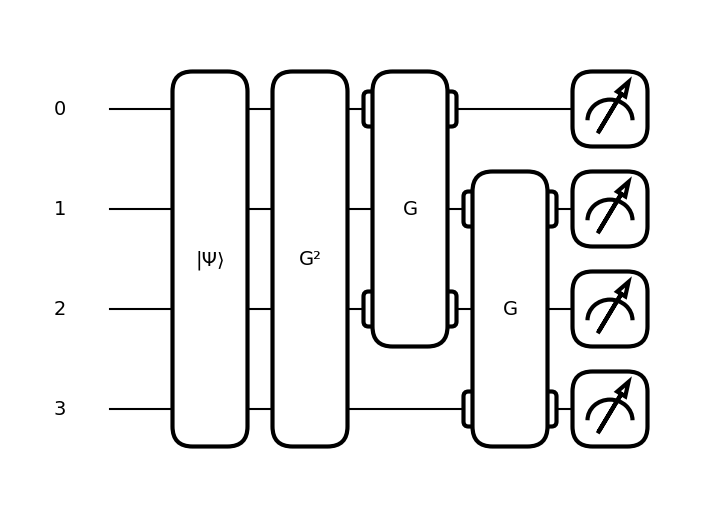

In [12]:
import matplotlib.pyplot as plt

fig, ax = qml.draw_mpl(vqe_circuit)(parameters)
plt.show()

### Complexity of VQE

The Variational Quantum Eigensolver (VQE) is a hybrid quantum classical algorithm composed of several interacting components, including quantum state preparation, measurement of observables, and classical optimization. As a result, the overall resource complexity of VQE can be understood as the combination of multiple contributing costs. At a high level, the total computational cost of VQE can be approximated as
$$
\text{Total Cost} \approx \text{\# Optimization Steps} \times \text{ Cost per Energy Evaluation }
$$
Each of these factors is itself composed of several subcomponents. The cost per energy evaluation depends on the number of Pauli terms in the Hamiltonian, the number of measurements required to estimate each expectation value to a desired precision, and any measurement grouping or error mitigation strategies employed. Similarly, the number of optimization steps depends on the choice of ansatz, the optimization landscape, and the classical optimizer used. A relevant question is which part of the VQE algorithm dominates the overall computational cost as the system size increases.



Recall that the VQE cost function is
$$
E(\boldsymbol{\theta}) = \sum_{i=1}^{N} h_i \langle P_i \rangle,
$$
where $N$ is the number of Pauli terms in the qubit Hamiltonian. For molecular systems, a Hamiltonian acting on $n$ qubits, corresponding to $n$ spin orbitals, contains $N = \mathcal{O}(n^4)$ Pauli terms. Each Pauli expectation value can be estimated through repeated measurements to reach a desired statistical precision. Consequently, the number of Pauli terms in the Hamiltonian decomposition is the dominant contributor to the computational cost of the VQE algorithm. For a detailed discussion, see [*The Variational Quantum Eigensolver: a review of methods and best practices*](https://arxiv.org/abs/2111.05176) by Jules Tilly et al. As stated in that review (page 12 of 156):

> The main bottleneck identified in these studies (based on noiseless estimates) is the substantial number of measurements that are required to estimate the expectation value of the Hamiltonian using VQE

To mitigate this challenge, several strategies have been proposed. One common approach is Pauli grouping, which groups Pauli strings into the same measurement setting when they commute, thereby reducing the number of circuit executions required. Another approach is to reduce the number of qubits by exploiting symmetries in the Hamiltonian through qubit tapering. For further discussion of qubit tapering, see the PennyLane tutorial at https://pennylane.ai/qml/demos/tutorial_qubit_tapering. In the worked example discussed earlier, qubit tapering was available but we did not utilize it. The attributes `dataset.tapered_hamiltonian` and `dataset.tapered_hf_state` provide the tapered Hamiltonian and the corresponding Hartree-Fock reference state, respectively. Applying tapering in this case would reduce the system from 4 qubits to 2 qubits, thereby reducing the size of the variational search space and the overall measurement cost. Additional details on tapering operations can be found in the PennyLane documentation at https://docs.pennylane.ai/en/stable/code/api/pennylane.taper_operation.html.

### Applications of Ground-State Energy

Now that we have explored the VQE algorithm and explained the physical principles behind it, we briefly consider some of the important applications of the ground-state energy, which is the objective of the VQE algorithm.

Knowing the ground-state energy level reveals many important inforamtion that have profound applications in chemistry and related fields such as drug discovery, condenser-matter physics and material sciece among other areas. See this [answer on Chemistry Stack Exchange](https://chemistry.stackexchange.com/a/153401/214512) for a quick overview.  Below we will consider some of its applications such computing the electric dipole, polarization and drug discovery. 

Thanks to the [Hellmann-Feynman theorem](https://en.wikipedia.org/wiki/Hellmann%E2%80%93Feynman_theorem), the ground-state energy serves as a foundation for computing various molecular properties. For instance, the electric dipole moment can be derived from energy derivatives. See [Moments-based quantum computation of the electric dipole moment of molecular systems](https://arxiv.org/abs/2509.10758v1) as an example. Similarly, atomic polarizability (the electric polarization of the electron cloud) is obtained by expanding the ground-state energy in the presence of an external electric field. See [Ab Initio Calculations of the Static and Dynamic Polarizability of BaOH](https://arxiv.org/abs/2510.19564v1) for an instance of this approach. These properties provide valuable information about solubility and dielectric properties (from dipole moments) and optical trapping capabilities (from polarizability), all of which can be derived from the ground state.

Furthermore, ground-state energy can be used to compute binding energies, which quantify the strength of protein-ligand interactions, a challenging component in drug discovery. While a complete treatment of drug binding requires calculating binding free energies, which include entropic and thermal effects, binding energies computed from ground states can serve as useful approximations for ranking drug candidates. Under certain simplifications, ground-state energy calculations can effectively prioritize compounds for further development. For a demonstration of this approach using VQE on quantum hardware to rank BACE1 inhibitors (Alzheimer's drug candidates), see [Quantum Computational Quantification of Protein-Ligand Interactions](https://arxiv.org/abs/2110.08163). For a comprehensive review of quantum computing's role in drug discovery, see [Quantum computing for near-term applications in generative chemistry and drug discovery](https://pubmed.ncbi.nlm.nih.gov/37331692/).

Ground-state energy has various applications across physics and chemistry, as we have described some of its applications. Beyond its direct role in determining molecular structure, the ground-state energy serves as the essential reference point for understanding excited states. The critical information lies in the energy differences between the ground and excited states. These differences directly correspond to the energies of photons absorbed or emitted by a molecule, forming the basis for all computational spectroscopy. Overall, the ground-state energy is a valuable quantity, as it encodes essential information about molecular structure, electronic interactions, and the physical behaviour of atoms and molecules.

### Conclusion

We introduced the Variational Quantum Eigensolver and explained that its objective is to approximate the ground-state energy of a Hamiltonian. A major portion of this tutorial was devoted to developing the mathematical and physical foundations needed to understand Hamiltonians, which provide a systematic way to describe the energy of a physical system. In particular, the ground-state energy of a Hamiltonian reveals many important properties of atomic and molecular systems and characterizes the most stable configuration of a system. This information underlies phenomena such as chemical bonding and reactions, and plays a central role in applications ranging from theoretical physics to quantum chemistry and drug discovery.


Additionally, we saw that there are several choices throughout the workflow that can affect the accuracy and efficiency of the algorithm. These include the choice of orbital basis used to truncate the Hamiltonian to a finite-dimensional space, the fermion-to-qubit mapping, and the choice of classical optimizer, among others. We also observed that the number of Pauli terms in the Hamiltonian decomposition plays a central role in the overall complexity of VQE, as it directly impacts the number of measurements required to estimate the energy. There are, however, strategies to mitigate this cost, such as Pauli grouping and qubit tapering, which reduces the size of the solution space by exploiting symmetries in the system. A comprehensive overview of these methods and related design choices can be found in [*The Variational Quantum Eigensolver: a review of methods and best practices*](https://arxiv.org/abs/2111.05176) by Jules Tilly et al.


While the Variational Quantum Eigensolver is a hybrid algorithm for estimating ground-state energies, it is not the first quantum algorithm proposed for this purpose. Ground-state energy estimation using quantum phase estimation was already explored in the 2005 paper [*Simulated Quantum Computation of Molecular Energies*](https://arxiv.org/abs/quant-ph/0604193) by Alán Aspuru-Guzik et al. Separately, the paper [*Quantum Computational Method of Finding the Ground State Energy and Expectation Values*](https://arxiv.org/abs/0712.0789) by Sangchul Oh presents an approach based on adiabatic evolution for computing ground-state energies. What distinguishes VQE from these earlier methods is its hybrid quantum–classical structure and its formulation for noisy intermediate-scale quantum (NISQ) devices, which makes it more suitable for execution on near-term quantum hardware.


---
### Appendix
---

### Appendix 1: Biography

 - William Rowan Hamilton (1805-1865) was an Irish mathematician, physicist, and astronomer who made foundational contributions to algebra, classical mechanics, and optics. While his formulation of Hamiltonian mechanics predates the development of quantum mechanics, but the mathematical framework he introduced later became central to electromagnetism, quantum mechanics, and quantum field theory. Hamilton spent most of his academic career as a professor at Trinity College Dublin. The Hamiltonian operator appearing in Schrödinger's equation is named in his honour. In addition, the Hamilton-Jacobi equation, Hamiltonian graphs, and Hamiltonian paths and cycles are named after him. He also introduced quaternions, a mathematical framework for describing rotations in three dimensions.

- Alán Aspuru-Guzik is a research scientist with a PhD in physical chemistry from the University of California, Berkeley. As of 2025, he is listed as a professor in the Department of Chemistry at the [University of Toronto](https://www.chemistry.utoronto.ca/people/directories/all-faculty/al%C3%A1n-aspuru-guzik), with a cross-appointment in the Department of Computer Science. He leads the Matter Lab at the University of Toronto, a research group working at the interface of theoretical chemistry, physics, computer science, and applied mathematics (https://www.linkedin.com/company/the-matter-lab-uoft/).

  The mission of the Matter Lab is described as (https://www.matter.toronto.edu/):

  > To accelerate the discovery of new chemicals and materials that are useful to society by means of new technologies such as quantum computing, machine learning, and automation.

  An overview of his scientific contributions, academic appointments, and entrepreneurial activities can be found at:  
  https://www.matter.toronto.edu/basic-content-page/about-alan

  Alán Aspuru-Guzik is a common author on both a quantum phase estimation–based approach to molecular ground-state energy estimation, presented in [*Simulated Quantum Computation of Molecular Energies*](https://arxiv.org/abs/quant-ph/0604193) (2005), and the original Variational Quantum Eigensolver paper, [*A Variational Eigenvalue Solver on a Quantum Processor*](https://arxiv.org/abs/1304.3061) (2013).

### Appendix 2: References and Suggested Readings

1. Peruzzo, Alberto; McClean, Jarrod; Shadbolt, Peter; Yung, Man-Hong; Zhou, Xiao-Qi; Love, Peter J.; Aspuru-Guzik, Alán; and O’Brien, Jeremy L. (2014). *A Variational Eigenvalue Solver on a Photonic Quantum Processor.* Nature Communications, 5, 4213. Available at: https://doi.org/10.1038/ncomms5213 [[arXiv](https://arxiv.org/abs/1304.3061)]

2. Aspuru-Guzik, Alán; Dutoi, Anthony D.; Love, Peter J.; and Head-Gordon, Martin (2005). *Simulated Quantum Computation of Molecular Energies.* Science, 309(5741), 1704-1707. Available at: https://doi.org/10.1126/science.1113479 [[arXiv](https://arxiv.org/abs/quant-ph/0604193)]

3. Tilly, Jules; Chen, Hongxiang; Cao, Shuxiang; Picozzi, Dario; Setia, Kanav; Li, Ying; Grant, Edward; Wossnig, Leonard; Rungger, Ivan; Booth, George H.; and Tennyson, Jonathan (2022). *The Variational Quantum Eigensolver: A Review of Methods and Best Practices.* Physics Reports, 986, 1-128. Available at: https://doi.org/10.1016/j.physrep.2022.08.003 [[arXiv](https://arxiv.org/abs/2111.05176)]

4. Arrazola, Juan Miguel; Di Matteo, Olivia; Quesada, Nicolás; Jahangiri, Soran; Delgado, Alain; and Killoran, Nathan (2022). *Universal Quantum Circuits for Quantum Chemistry.* Quantum, 6, 742. Available at: https://doi.org/10.22331/q-2022-06-20-742 [[arXiv](https://arxiv.org/abs/2106.13839)]

5. Pyrkov, Alexander; Aliper, Alex; Bezrukov, Dmitry; Lin, Yu-Chen; Polykovskiy, Daniil; Kamya, Pranav; Ren, Fei; and Zhavoronkov, Alex (2023). *Quantum Computing for Near-Term Applications in Generative Chemistry and Drug Discovery.* Drug Discovery Today, 28(8). Available at: https://doi.org/10.1016/j.drudis.2023.103675

6. Lee, Joonho; Huggins, William J.; Head-Gordon, Martin; and Whaley, K. Birgitta (2019). *Generalized Unitary Coupled Cluster Wave Functions for Quantum Computation.* Journal of Chemical Theory and Computation, 15(1), 311-324. Available at: https://doi.org/10.1021/acs.jctc.8b01004 [[arXiv](https://arxiv.org/abs/1810.02327)]

7. Romero, Jonathan; Babbush, Ryan; McClean, Jarrod R.; Hempel, Cornelius; Love, Peter J.; and Aspuru-Guzik, Alán (2018). *Strategies for Quantum Computing Molecular Energies Using the Unitary Coupled Cluster Ansatz.* Quantum Science and Technology, 4(1), 014008. Available at: https://doi.org/10.1088/2058-9565/aad3e4 [[arXiv](https://arxiv.org/abs/1701.02691)]

8. Kirsopp, Josh J. M.; Di Paola, Cono; Manrique, David Zsolt; Krompiec, Michal; Greene-Diniz, Gabriel; Guba, Wolfgang; Meyder, Agnes; Wolf, Detlef; Strahm, Martin; and Muñoz Ramo, David (2022). *Quantum Computational Quantification of Protein–Ligand Interactions.* International Journal of Quantum Chemistry, 122(22). Available at: https://doi.org/10.1002/qua.26975 [[arXiv](https://arxiv.org/abs/2110.08163)]

9. Oh, Sangchul (2008). *Quantum Computational Method of Finding the Ground-State Energy and Expectation Values.* Physical Review A, 77(1), 012326. Available at: https://doi.org/10.1103/PhysRevA.77.012326 [[arXiv](https://arxiv.org/abs/0712.0789)]

10. Jones, Michael A.; Vallury, Harish J.; Per, Manolo C.; Quiney, Harry M.; and Hollenberg, Lloyd C. L. (2025). *Moments-Based Quantum Computation of the Electric Dipole Moment of Molecular Systems.* [arXiv:2509.10758](https://arxiv.org/abs/2509.10758). 

11. Prinsen, E. H.; Borschevsky, A.; Hoekstra, S.; Dutta, A. K.; Chakraborty, S.; Schellenberg, B. J.; Pašteka, L. F.; and Aucar, I. A. (2025). *Ab Initio Calculations of the Static and Dynamic Polarizability of BaOH.* [arXiv:2510.19564](https://arxiv.org/abs/2510.19564). 


In addition to the works discussed above, there exists a broad ecosystem of tutorials, demonstrations, and software resources that support practical implementations of VQE and related quantum chemistry workflows. Below, we list a selection of such resources:

 - Alain Delgado Gran. *A Brief Overview of VQE*. Available at: https://pennylane.ai/qml/demos/tutorial_vqe/
 - Utkarsh Azad; Soran Jahangiri. *Qubit Tapering*. Available at: https://pennylane.ai/qml/demos/tutorial_qubit_tapering
 - Diksha Dhawan; Soran Jahangiri. *How to Build Spin Hamiltonians*. Available at: https://pennylane.ai/qml/demos/tutorial_how_to_build_spin_hamiltonians
 - Diksha Dhawan. *Mapping Fermionic Hamiltonians to Qubit Hamiltonians*. Available at: https://pennylane.ai/qml/demos/tutorial_mapping
 - Soran Jahangiri. *Fermionic operators*. Available at: https://pennylane.ai/qml/demos/tutorial_fermionic_operators
 - Luis Mantilla Calderon. *How to Create Your Own Optimizer*. Available at: https://pennylane.ai/blog/2022/07/how-to-create-your-own-optimizer
 - Roeland Wiersema. *How to Construct and Load Hamiltonians in PennyLane*. Available at: https://pennylane.ai/blog/2021/05/how-to-construct-and-load-hamiltonians-in-pennylane
 - Juan Miguel Arrazola. *Givens Rotations for Quantum Chemistry*. Available at: https://pennylane.ai/qml/demos/tutorial_givens_rotations
 - Josh Izaac. *Measurement Optimization*. Available at: https://pennylane.ai/qml/demos/tutorial_measurement_optimize
 - Alain Delgado Gran. *Building Molecular Hamiltonians*. Available at: https://pennylane.ai/qml/demos/tutorial_quantum_chemistry
 - Thomas Bromley. *VQE with Parallel QPUs with Rigetti*. Available at: https://pennylane.ai/qml/demos/vqe_parallel
 - Roeland Wiersema, Brian Doolittle, *Classical Shadows*. Available at: https://pennylane.ai/qml/demos/tutorial_classical_shadows
 - PennyLane. *Quantum Data*. Available at: https://pennylane.ai/datasets
 - PennyLane. *Circuit Ansatz*. Available at: https://pennylane.ai/qml/glossary/circuit_ansatz
 - QuEra. *Ground State*. Available at: https://www.quera.com/glossary/ground-state
 - QuEra. *Variational Quantum Eigensolver (VQE)*. Available at: https://www.quera.com/glossary/variational-quantum-eigensolver
 - QuEra. *Hamiltonian*. Available at: https://www.quera.com/glossary/hamiltonian
 - IBM Quantum Platform. *Quantum Diagonalization Algorithms - The Variational Quantum Eigensolver (VQE) Lesson*. Available at: https://quantum.cloud.ibm.com/learning/en/courses/quantum-diagonalization-algorithms/vqe
 - IBM Quantum Platform. *Quantum Chemistry with VQE Course*. Available at: https://quantum.cloud.ibm.com/learning/en/courses/quantum-chem-with-vqe
 - Qiskit Nature. *Qiskit Nature Overview*. Available at: https://qiskit-community.github.io/qiskit-nature/
 - Quantum AI. *OpenFermion: The open source chemistry package for quantum computers*. Available at: https://quantumai.google/openfermion
 - PySCF. *PySCF: Python-based Simulations of Chemistry Framework*. Available at: https://pyscf.org/. [[GitHub](https://github.com/pyscf/pyscf)]
 - Psi4. *Psi4: Open-Source Quantum Chemistry – an electronic structure package in C++ driven by Python*. Available at: https://psicode.org/. [[GitHub](https://github.com/psi4/psi4)]
 - Gaussian. *Gaussian: Expanding the Limits of Computational Chemistry*. Available at: https://gaussian.com/. 

<sup>1</sup> **Ansatz:** In variational quantum algorithms, an ansatz refers to a parameterized quantum circuit that prepares a family of trial states
$$
|\psi(\boldsymbol{\theta}) \rangle = U(\boldsymbol{\theta}) |0 \rangle .
$$
Equivalently, an ansatz defines a family of circuits $\mathcal{A}$ of the form
$$
\mathcal{A} = \left\{ U(\boldsymbol{\theta}) \;\middle|\; \boldsymbol{\theta} \in \mathbb{R}^k \right\} \quad \text{where} \quad \boldsymbol{\theta} = (\theta_1, \theta_2, \ldots, \theta_k).
$$

The word *ansatz* is German and refers to an educated guess or an auxiliary assumption introduced to help solve a problem, which may later be justified by the correctness of the resulting solution ([Wikipedia](https://en.wikipedia.org/wiki/Ansatz)). In the literature, multiple plural forms of *ansatz* are used. Some sources retain the original German plural *ansätze*. Other sources use the spelling *ansaetze*, which appears, for example, in the [PennyLane documentation](https://pennylane.ai/qml/glossary/circuit_ansatz#footnote-1). Additionally, some works use the plural form *ansatzes*, such as in [*Variational Quantum Algorithms*](https://arxiv.org/abs/2012.09265) by Cerezo *et al.* As a result, all three forms, *ansätze*, *ansaetze*, and *ansatzes*, are encountered in the quantum computing literature.


